# A Gentle (Mathematicians) Introduction to PyTorch and Neural Networks Part 02
#### Todo: Change intro
In this blog posts, I'd like to introduce a commonly used optimizer for training models such as the logistic model we introduced in the [last post](https://linus-lach.de/posts/post-with-code/pytorch/post_01).

The structure of this post is as follows:
First, we familiarize ourselves a bit with the `PyTorch` framework. To build on this newly gained knowledge, we build a logistic model with `PyTorch` and gain some understanding about the binary cross-entropy loss in a theoretical setting.
In the final part we will learn how to train our logistic regression model to achieve a good fit on given data.

## (Stochastic) gradient descent

In [2]:
#Some packages needed throughout the article
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


## (Stochastic) Gradient Descent


(-2.0, 10.0)

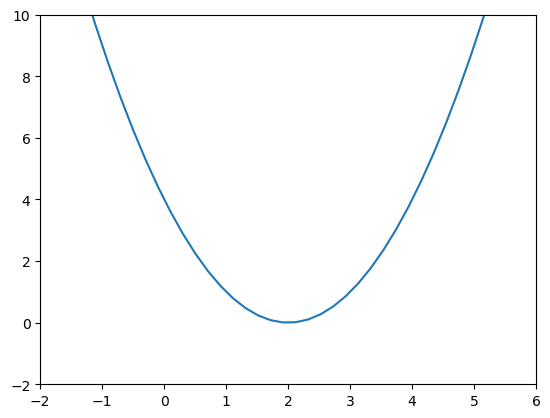

In [3]:
N=100
X = np.linspace(-10,10,N)
def f(x):
    return (x-2)**2
plt.plot(X,f(X))
plt.xlim((-2,6))
plt.ylim((-2,10))


In [4]:
def gd_1d(epochs ,lr ,f ,x):
    coord = []
    for epoch in range(epochs):
        loss = f(x)
        coord.append([x.data,loss.data])
        loss.backward()
        x.data = x.data - lr * x.grad.data
        x.grad.data.zero_()

    return np.transpose(np.reshape(coord,(epochs,2)))


In [5]:
x0 = torch.tensor(-1.0,requires_grad=True)
lr = 0.1
epochs = 20
coord = gd_1d(epochs,lr,f,x0)


In [6]:
print(np.round(coord,3))

[[-1.000e+00 -4.000e-01  8.000e-02  4.640e-01  7.710e-01  1.017e+00
   1.214e+00  1.371e+00  1.497e+00  1.597e+00  1.678e+00  1.742e+00
   1.794e+00  1.835e+00  1.868e+00  1.894e+00  1.916e+00  1.932e+00
   1.946e+00  1.957e+00]
 [ 9.000e+00  5.760e+00  3.686e+00  2.359e+00  1.510e+00  9.660e-01
   6.180e-01  3.960e-01  2.530e-01  1.620e-01  1.040e-01  6.600e-02
   4.300e-02  2.700e-02  1.700e-02  1.100e-02  7.000e-03  5.000e-03
   3.000e-03  2.000e-03]]


(-2.0, 10.0)

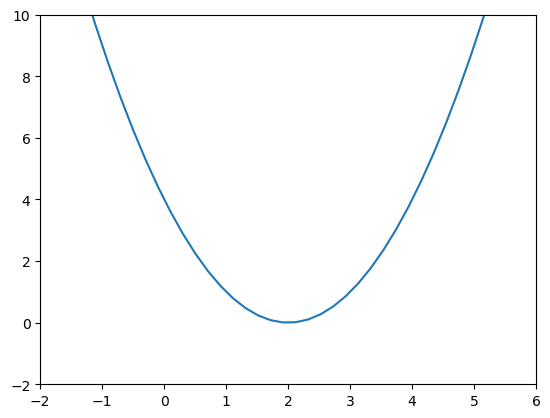

In [7]:
plt.plot(X,f(X))
plt.xlim((-2,6))
plt.ylim((-2,10))


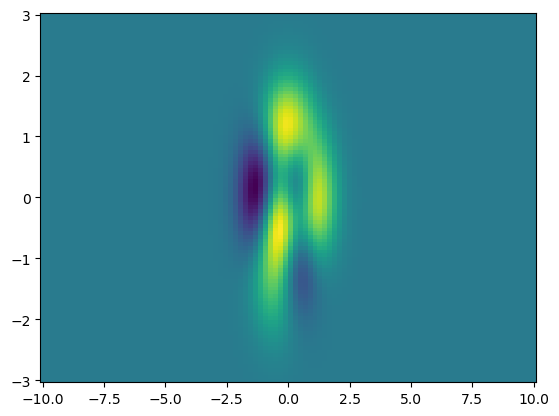

In [8]:
Y = np.linspace(-3,3,N)
def f(x, y):
    res = 2*(2-x)**2*(np.exp(-1*(x**2)-(y+1)**2))-15*(1/5*x-x**3-y**3)*np.exp(-x**2 - y**2)-1/3*np.exp(-(x + 1)**2 - y**2)
    return res

f = np.vectorize(f)
XX,YY = np.meshgrid(X,Y)
ZZ = f(XX,YY)
plt.pcolor(XX, YY, ZZ)

In [14]:
def f_(x,y):
    return 2*(2-x)**2*(torch.exp(-1*(x**2)-(y+1)**2))-15*(1/5*x-x**3-y**3)*torch.exp(-x**2 - y**2)-1/3*torch.exp(-(x + 1)**2 - y**2)

In [15]:
def train_model_GD(iter,lr,f,x1,x2):
    COORD = []
    for epoch in range(iter):
        loss = f(x1,x2)
        COORD.append([x1.data,x2.data,loss.data])
        loss.backward()
        x1.data = x1.data - lr * x1.grad.data
        x2.data = x2.data - lr * x2.grad.data

        x1.grad.data.zero_();x2.grad.data.zero_()

    return np.transpose(np.reshape(COORD,(n,3)))


In [16]:
print(f_(x1,x2))

tensor(5.3972, grad_fn=<SubBackward0>)


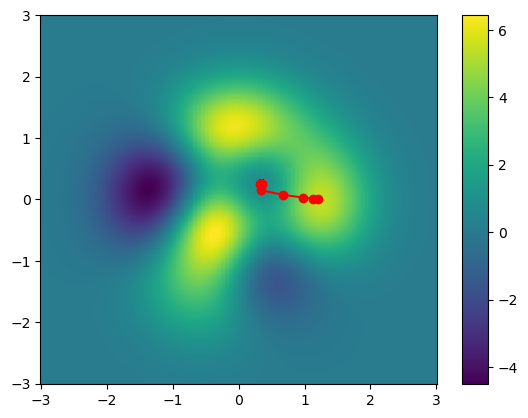

In [17]:
n = 1000
lr = 0.05
x1 = torch.tensor(1.2, requires_grad=True)
x2 = torch.tensor(0.0, requires_grad=True)
COORD = train_model_GD(n, lr, f_, x1, x2)
plt.pcolor(XX, YY, ZZ)
plt.plot(COORD[0], COORD[1], 'o-r')
plt.colorbar(shrink=1, aspect=14)
plt.show()